In [61]:
import os
import numpy as np
import pandas as pd
import cvxpy as cp
#import cplex
import osqp
import matplotlib.pyplot as plt

In [82]:
# tool for pretty plots with mean + std
def lineplotCI(x, y, low, up, c, alp = 0.2):
    plt.plot(x, y, lw = 2, color = c, alpha = 1)
    plt.fill_between(x, low, up, color = c, alpha = alp)

In [62]:
def read_data_mat100(dataset="tr0"):
    folder = "kernel-methods-for-machine-learning-2018-2019"
    features_file = "X" + dataset + "_mat100.csv"
    labels_file = "Y" + dataset + ".csv"
    
    X = pd.read_csv(
        os.path.join(folder, features_file),
        sep=" ",
        header=None
    )
    if "te" in dataset:
        return np.array(X)
    
    elif "tr" in dataset:
        Y = pd.read_csv(
            os.path.join(folder, labels_file),
            sep=",",
            index_col=0,
        )
        return np.array(X), 2 * np.array(Y.iloc[:, 0]) - 1

In [12]:
def kernel(x1, x2):
    return x1.dot(x2)

lambd = 1

In [13]:
def compute_predictor(Xtr, Ytr, kernel, lambd):
    m = Xtr.mean(axis=0)
    s = Xtr.std(axis=0)
    Xc = (Xtr - m)/s

    n = len(Xc)

    I = np.eye(n)
    U = (1/n) * np.ones((n, n))
    gram_matrix = kernel(Xc, Xc.T)
    K = gram_matrix + 1e-9*I
    
    alpha = cp.Variable(n)

    constraints = [
        cp.multiply(Ytr, alpha) >= np.zeros(n),
        cp.multiply(Ytr, alpha) <= np.ones(n) / (2 * lambd * n)
    ]

    objective = cp.Minimize(
        - 2 * (Ytr * alpha)
        + cp.quad_form(alpha, K)
    )

    prob = cp.Problem(objective, constraints)

    result = prob.solve(solver=cp.OSQP, verbose=False)
    
    return lambda x_new: np.sign(alpha.value.dot(kernel(Xc, (x_new - m)/s)))

In [56]:
def cross_validate(X, Y, kernel, lambd, p=0.9, shuffle = True, kfold = 5):
    acc_train, acc_val = np.zeros(kfold), np.zeros(kfold)
    
    for k in range(kfold):
        # jointly shuffle input datasets X, Y
        n = X.shape[0]
        if shuffle:
            perm = np.random.permutation(n)
            X, Y = X[perm], Y[perm]

        # split the datasets
        n_train = int(p*n)
        n_val = n - n_train
        X_train = X[:n_train]
        Y_train = Y[:n_train]
        X_val = X[n_train:]
        Y_val = Y[n_train:]

        # fit the predictor
        f = compute_predictor(X_train, Y_train, kernel, lambd)

        Yte_train = np.array([f(X_train[i]) for i in range(n_train)])
        Ypred_train = list(((Yte_train + 1) / 2).astype(int))

        Yte_val = np.array([f(X_val[i]) for i in range(n_val)])
        Ypred_val = list(((Yte_val + 1) / 2).astype(int))
        
        Y_train = list(((Y_train + 1) / 2).astype(int))
        Y_val = list(((Y_val + 1) / 2).astype(int))
        
        #print(np.array(Ypred_train) - np.array(Y_train))
        # compute metrics
        acc_train[k] = 1. - np.sum(np.abs(np.array(Ypred_train) - np.array(Y_train)))/n_train
        acc_val[k] = 1. - np.sum(np.abs(np.array(Ypred_val) - np.array(Y_val)))/n_val

    return acc_train, acc_val

### Grid search on lambda (on each dataset)

In [87]:
lambd_range = [1e-1, 2e-1, 5e-1, 1., 2.]
acc_train = np.zeros((len(lambd_range), 5))
acc_val = np.zeros((len(lambd_range), 5))
for i, lambd in enumerate(lambd_range):
    Xtr, Ytr = read_data_mat100("tr" + str(2))
    acc_train[i], acc_val[i] = cross_validate(Xtr, Ytr, kernel, lambd, p=0.9, shuffle = True, kfold = 5)
    print('Lambda: ', lambd)
    print('Train accuracy: ', np.mean(acc_train[i]))
    print('Valid accuracy: ', np.mean(acc_val[i]))
    print('------------')

Lambda:  0.1
Train accuracy:  0.6626666666666667
Valid accuracy:  0.603
------------
Lambda:  0.2
Train accuracy:  0.6565555555555556
Valid accuracy:  0.624
------------
Lambda:  0.5
Train accuracy:  0.6428888888888888
Valid accuracy:  0.582
------------
Lambda:  1.0
Train accuracy:  0.642888888888889
Valid accuracy:  0.6010000000000001
------------
Lambda:  2.0
Train accuracy:  0.6458888888888887
Valid accuracy:  0.6119999999999999
------------


Text(0,0.5,'accuracy')

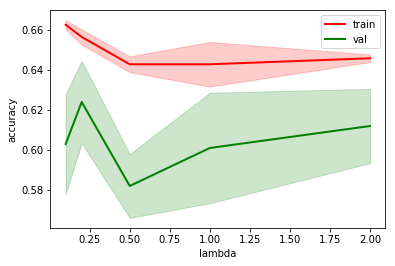

In [88]:
plt.figure()
lineplotCI(lambd_range, acc_train.mean(axis=1), acc_train.mean(axis=1)+acc_train.std(axis=1),
           acc_train.mean(axis=1)-acc_train.std(axis=1), c='r')
lineplotCI(lambd_range, acc_val.mean(axis=1), acc_val.mean(axis=1)+acc_val.std(axis=1),
           acc_val.mean(axis=1)-acc_val.std(axis=1), c='g')
plt.legend(['train', 'val'])
plt.xlabel('lambda')
plt.ylabel('accuracy')

### Make the final predictions

In [89]:
Ypred = []
lambd = 0.

for k in [0, 1, 2]:
    print("\nDATASET {}\n".format(k))

    Xtr, Ytr = read_data_mat100("tr" + str(k))
    Xte = read_data_mat100("te" + str(k))
    
    if k==0:
        lambd = .2
    elif k==1:
        lambd = 1.
    elif k==2:
        lambd = .2
    
    f = compute_predictor(Xtr, Ytr, kernel, lambd)
    Yte = np.array([f(Xte[i]) for i in range(len(Xte))])
    
    Ypred.extend(list(((Yte + 1) / 2).astype(int)))
    
Ypred = pd.Series(
    index=np.arange(len(Ypred)),
    data=Ypred
)
Ypred.index.name = "Id"
Ypred.name = "Bound"
Ypred.to_csv("Ypred.csv", header=True)


DATASET 0


DATASET 1


DATASET 2

